In [1]:
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
# from utils import mpl_stylesheet
# mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)

from scipy.stats import ortho_group

# from sklearn.decomposition import PCA

In [2]:
N = 100
P = 5000

In [15]:
def plot_with_gaussian(Q, ax, label):
    
    muQ = np.mean(Q)
    sigmaQ = np.std(Q)
    
    xmax = muQ + 4.0 * sigmaQ
    xmin = muQ - 4.0 * sigmaQ
    bins = np.linspace(xmin, xmax, 50)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], 100)
    ax.hist(Q, bins = bins, density = True, alpha = 0.3, label = '{:s} iter'.format(label))
    
    rv = stats.norm(loc = muQ, scale = sigmaQ)
    ax.plot(x, rv.pdf(x), label = '{:s} Normal'.format(label))
    
    return

def getQ(X, Y, Ysep, ax1, ax2, nComp):
    niter = 2000
    N = X.shape[0]
    
    _, S, Vt = np.linalg.svd(Y, full_matrices=False)
    U = ortho_group.rvs(dim = N)
    #U = np.eye(N)

    ### Snew from different matrix
    _, Snew, _ = np.linalg.svd(Ysep, full_matrices=False)
    
    ### Snew sampled from Gaussian
    #Snew = np.sort(np.random.normal(loc = np.mean(S), scale = np.std(S), size = N))[::-1]
    
    ### S1, S2 from Snew
    fact = np.median(Snew)
    S1 = Snew / (Snew + fact)
    S2 = Snew.copy()
    S2[:nComp] = 1e-10
    S2 = np.sort(S2)[::-1]
    S2 = S2 / (S2 + fact)
    
    ### S1, S2 from Heavyside step function.
#     S1 = np.repeat(0.53, N)
#     S1[-int(N/2):] = 0
#     S2 = S1.copy()
#     S2[:nComp] = 1e-10
#     S2 = np.sort(S2)[::-1]
    
    ### S1, S2 fom Snew, forced lower components to zero
#     fact = np.median(Snew)
#     S1 = Snew / (Snew + fact)
#     S1[-int(N/2):] = 1e-10
#     S2 = S1.copy()
#     S2[:nComp] = 1e-10
#     S2 = np.sort(S2)[::-1]
    
    Q1 = np.zeros(niter)
    Q2 = np.zeros(niter)
    
    for i in range(niter):
        np.random.shuffle(X)
        # X = np.random.normal(loc = 0, scale = 1, size = N)
        # X = (X - np.mean(X))
        # X = X / np.linalg.norm(X)
        for j in range(N):
            utx = np.dot(U[:, j], X)
            #utx_pca = np.dot(U_pca[:, j], X)
            Q1[i] += np.square(utx) * S1[j]
            Q2[i] += np.square(utx) * S2[j]
            
    plot_with_gaussian(Q1, ax1, 'Full')
    plot_with_gaussian(Q2, ax2, 'Clipped')
    
    return S1, S2, Q1, Q2

def center_and_scale(Y):
    newY = (Y - np.mean(Y, axis = 1).reshape(-1, 1)) / np.std(Y, axis = 1).reshape(-1, 1)
    return newY

In [16]:
# X = getX(N)
X = np.random.normal(loc = 0, scale = 1, size = N)
X = X - np.mean(X)
X = X / np.linalg.norm(X)

Y = np.random.normal(loc = 0, scale = 1, size = N * P).reshape(N, P)
Ysep = np.random.normal(loc = 0, scale = 1, size = N * P).reshape(N, P)

Y = center_and_scale(Y) / np.sqrt(N)
Ysep = center_and_scale(Ysep) / np.sqrt(N)
#Y = center_and_scale(Y)

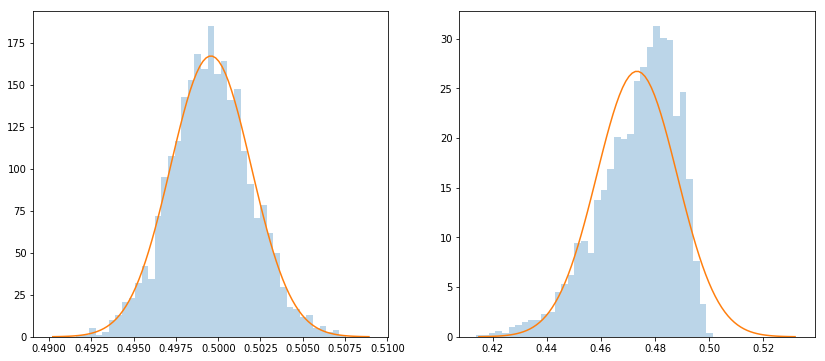

In [17]:
fig = plt.figure(figsize = (14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nComp = 5
S1, S2, Q1, Q2 = getQ(X, Y, Ysep, ax1, ax2, nComp)

plt.show()

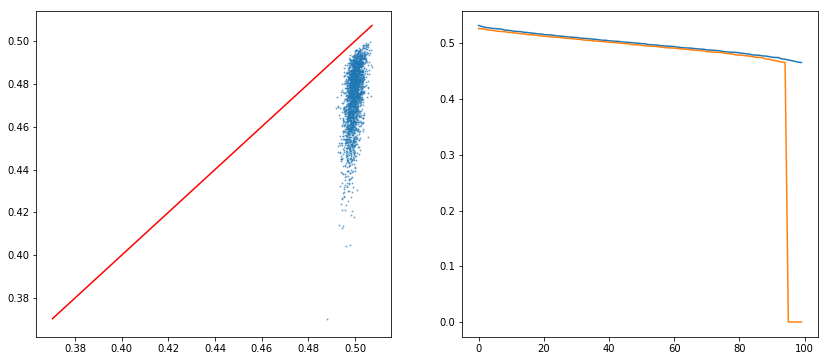

In [18]:
fig = plt.figure(figsize = (14, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(Q1, Q2, s = 1, alpha = 0.5)
Qmin = min(np.min(Q1), np.min(Q2))
Qmax = max(np.max(Q1), np.max(Q2))
ax1.plot([Qmin, Qmax], [Qmin, Qmax], color = 'red')
ax2.plot(np.arange(N), S1)
ax2.plot(np.arange(N), S2)
plt.show()